In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from collections import defaultdict
sns.set(rc={'figure.figsize':(12, 12)})

In [128]:
# This function assumes you have all stack overflow data saved locally in the following format survey_results_public_year.csv
def create_year_dataframe(year):
    
    '''
    INPUT:
    year - an integer. The year you would like to analyze
    
    OUTPUT:
    df - a dataframe of survey results for that year
    '''
    
    df = pd.read_csv("survey_results_public_" + str(year) + ".csv", low_memory=False)
    return df

In [129]:
years_data = [2015, 2016, 2017, 2018, 2019]

In [130]:
def create_all_dataframes(all_years):
    
    '''
    INPUT:
    years - A list of all the years you would like to analyze
    
    OUTPUT:
    dict_df - a dictionary where the year is the key and a dataframe is the value
    '''
    dict_df = {}
    for year in years_data:
        dict_df[year] = create_year_dataframe(year)
    return dict_df

In [131]:
# I'm creating a dictionary with stackoverflow dataframes from 2015-2019
all_years = create_all_dataframes(years_data)

In [132]:
#cleaning 2015 headers
columns_2015 = all_years[2015].iloc[0]
all_years[2015] = all_years[2015][1:]
all_years[2015].columns = columns_2015

In [133]:
def segment_by_column_equal_to_value(df, column, value):
    '''
    INPUT:
    df - A data frame you want to split
    column - a column you would like to segment by
    value - The value you want to use to group the data
    
    OUTPUT:
    df - a new dataframe that only contains the values you want in your column 
    '''
    return df[df[column]==value]

In [134]:
# I'm renaming the 2016 column country to Country, so all data is consistent
all_years[2016].rename(columns={"country":"Country"}, inplace=True)

In [135]:
def segment_dict_by_column_equal_to_value(df_dict, column, value):
    '''
    INPUT:
    df_dict - A dictionary of dataframes you want to split
    column - a column you would like to segment by
    value - The value you want to use to group the data
    
    OUTPUT:
    dictionary - a new dictionary that contains only the values you want in your column for each year
    '''
    dictionary = {}
    for key in df_dict:
        dictionary[key] = segment_by_column_equal_to_value(df_dict[key], column, value)
    return dictionary

In [136]:
# Get united states data for all years
united_states = segment_dict_by_column_equal_to_value(all_years, "Country", "United States")

<H2> Question 1: How has the survey changed over the years? </h2>

In [137]:
def get_yearly_shape(dictionary, year):
    '''
    INPUT:
    dictionary - A dictionary with year keys and dataframe values
    year - the year you want to analyze
    
    OUTPUT:
    The amount of respondents and questions for that year
    '''
    return dictionary[year].shape[0], dictionary[year].shape[1]

In [138]:
def get_all_shapes(dictionary, years):
    '''
    INPUT:
    dictionary - A dictionary with year keys and dataframe values
    years - All the years you want to analyze
    
    OUTPUT:
    df - A dataframe with the amount of respondents and questions for each year
    '''
    rows = []
    columns = []
    for year in years:
        rows.append(get_yearly_shape(dictionary, year)[0])
        columns.append(get_yearly_shape(dictionary, year)[1])
    df = pd.DataFrame(list(zip(rows, columns, years)), columns=["NumberOfRespondents", "NumberOfQuestions", "Year"])
    return df
        

In [139]:
# I get the shape for each year from 2015 - 2019
yearly_shapes = get_all_shapes(united_states, [2015, 2016, 2017, 2018, 2019])

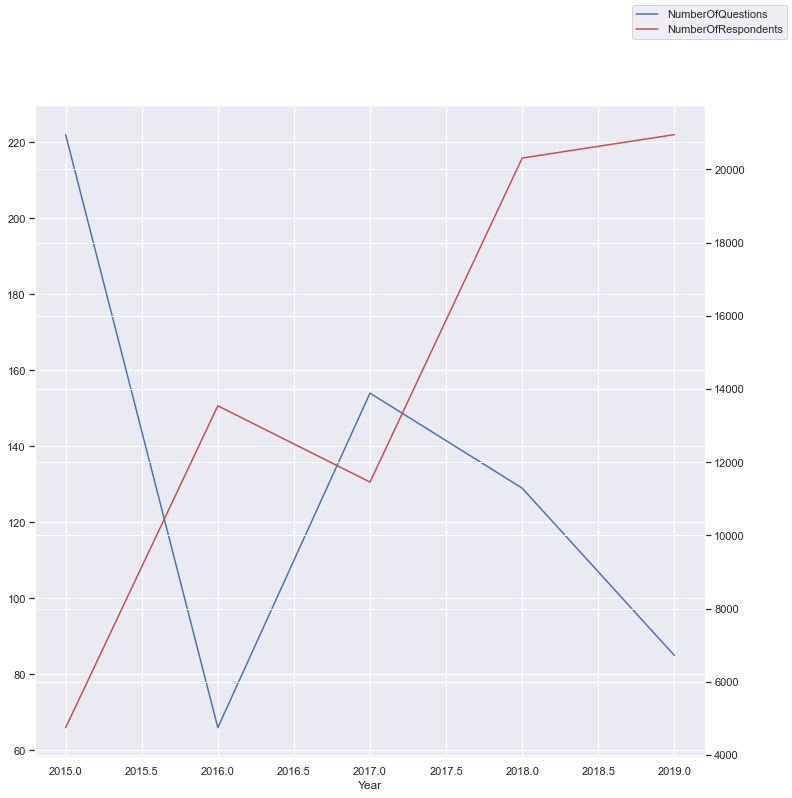

In [140]:
# A line graph of questions and respondents over time. It looks likes questions and respondents are inversely correlated. 

ax = yearly_shapes.plot(x="Year", y="NumberOfQuestions", legend=False)
ax2 = ax.twinx()
yearly_shapes.plot(x="Year", y="NumberOfRespondents", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

<H2> Question 2: How have the most common occupations changed in the United States over the last 3 years </h2>

In [141]:
united_states[2015]["Occupation"].unique()

array(['Back-end web developer',
       'Business intelligence or data warehousing expert',
       'Data scientist', 'Database administrator', 'Designer',
       'Desktop developer',
       'Developer with a statistics or mathematics background', 'DevOps',
       'Embedded application developer',
       'Enterprise level services developer',
       'Executive (VP of Eng., CTO, CIO, etc.)',
       'Front-end web developer', 'Full-stack web developer',
       'Graphics programmer', 'Growth hacker',
       'Machine learning developer', 'Mobile developer',
       'Mobile developer - Android', 'Mobile developer - iOS',
       'Mobile developer - Windows Phone', 'Product manager',
       'Quality Assurance', 'Student', 'System administrator', nan],
      dtype=object)

In [142]:
united_states[2016]["occupation"].unique()

array([nan, 'DevOps', 'Full-stack web developer', 'Desktop developer',
       'Mobile developer - iOS', 'Student', 'Front-end web developer',
       'Quality Assurance', 'other', 'Machine learning developer',
       'Engineering manager', 'Back-end web developer',
       'System administrator', 'Data scientist', 'Mobile developer',
       'Mobile developer - Android',
       'Executive (VP of Eng., CTO, CIO, etc.)', 'Analyst',
       'Embedded application developer',
       'Business intelligence or data warehousing expert',
       'Enterprise level services developer', 'Database administrator',
       'Developer with a statistics or mathematics background',
       'Designer', 'Growth hacker', 'Graphics programmer',
       'Product manager', 'Mobile developer - Windows Phone'],
      dtype=object)

In [143]:
#united_states[2017]["DeveloperType"].unique()

In [144]:
united_states[2018]["DevType"].unique()

array(['Engineering manager;Full-stack developer', 'Full-stack developer',
       'Back-end developer;Front-end developer;Full-stack developer', ...,
       'Embedded applications or devices developer;Full-stack developer;Student',
       'Back-end developer;Designer;Engineering manager;Mobile developer;Student',
       'Desktop or enterprise applications developer;Embedded applications or devices developer;Game or graphics developer;Student'],
      dtype=object)

<p>From 2015 to 2019, StackOverflow changed the name of the occupation column. We will standardize the column.</p>
<p>You might also notice starting in 2017 respondents can submit multiple answers. </p>
<p>We will split semi-colon results, and standardize respondents across years with a regex </p>

In [145]:
#I used this function for 2015 and 2016

def create_value_df(dictionary, year, column_name, new_column_name):
    '''
    INPUT:
    dictionary - A dictionary with year keys and dataframe values
    year - The year you want to analyze
    column_name - The column you want analyze
    new_column_name - This name replaces the old column, so you can standardize names
    
    OUTPUT:
    new_df - A dataframe with four columns - Developer Type, Respondent count, Percentage, and Year
    '''
    
    new_df = pd.DataFrame(dictionary[year][column_name].value_counts()).reset_index()
    new_df.columns=[new_column_name, "Count"]
    new_df["Percentage"] = new_df["Count"]/sum(new_df["Count"])
    new_df = new_df.groupby(new_column_name, as_index=False).sum()
    new_df["Year"] = year
    new_df.sort_values("Percentage", ascending=False, inplace=True)
    return new_df

In [146]:
# Starting in 2017, we have to split semicolons
def split_words(dictionary, year, column_name, new_column_name):
    '''
    INPUT:
    dictionary - A dictionary with year keys and dataframe values
    year - The year you want to analyze
    column_name - The column you want analyze
    new_column_name - This name replaces the old column, so you can standardize names
    
    OUTPUT:
    new_df - A dataframe with four columns - Developer Type, Respondent count, Percentage, and Year
    '''
    all_the_words = defaultdict(int)
    for row in dictionary[year][column_name]:
        if isinstance(row, float):
            all_the_words[row] += 1
        else:
            for word in row.split(";"):
                all_the_words[word.strip()] += 1
    new_df = pd.DataFrame(pd.Series(all_the_words)).reset_index()
    new_df.columns = [new_column_name, "Count"]
    new_df["Percentage"] = new_df["Count"] / sum(new_df["Count"])
    new_df["Year"] = year
    new_df.sort_values('Percentage', ascending=False, inplace=True)
    return new_df

In [147]:
#Creating individual dataframes. I removed 2017 from the results.
#StackOverflow changed how occupation options that year and reverted back in 2018

occupation_2015 = create_value_df(united_states, 2015, "Occupation", "DeveloperType")
occupation_2016 = create_value_df(united_states, 2016, "occupation", "DeveloperType")
#occupation_2017 = split_words(all_years, 2017, "DeveloperType", "DeveloperType")
occupation_2018 = split_words(united_states, 2018, "DevType", "DeveloperType")
occupation_2019 = split_words(united_states, 2019, "DevType", "DeveloperType")

In [148]:
occupation_2015

,DeveloperType,Count,Percentage,Year
12,Full-stack web developer,1371,0.344992,2015
22,Student,516,0.129844,2015
5,Desktop developer,326,0.082033,2015
0,Back-end web developer,310,0.078007,2015
11,Front-end web developer,216,0.054353,2015
9,Enterprise level services developer,136,0.034222,2015
19,Mobile developer - iOS,130,0.032713,2015
8,Embedded application developer,121,0.030448,2015
2,Data scientist,106,0.026673,2015
7,Developer with a statistics or mathematics bac...,105,0.026422,2015


In [149]:
occupation_2019

,DeveloperType,Count,Percentage,Year
0,"Developer, full-stack",10628,0.172976,2019
3,"Developer, back-end",8885,0.144608,2019
5,"Developer, front-end",6103,0.099329,2019
4,"Developer, desktop or enterprise applications",3989,0.064923,2019
6,"Developer, mobile",2631,0.042821,2019
2,Database administrator,2352,0.038280,2019
7,DevOps specialist,2337,0.038036,2019
13,Designer,2313,0.037645,2019
12,System administrator,2227,0.036246,2019
18,Student,2037,0.033153,2019


In [150]:
# Notice how full-stack is different in 2015 and 2019. We will standardize for our graph.

In [151]:
occupation_df = occupation_2015.append(occupation_2016).append(occupation_2018).append(occupation_2019)

In [152]:
#Terms change from year to year, so we will standardize occupations using a regex
def standardize_developer_types(df, regexes, words):
    '''
    INPUT:
    df - Your dataframe. This function will look for regexes and replace them with a word of your choice, 
         so you can standardize names for several years 
    regexes - A list of regexes to identify what strings to change
    words - A new list of terms you would like to use
    
    OUTPUT:
    new_df - A dataframe with standardized names
    '''
    new_df = df.replace(regexes, words, regex=True)
    return new_df

In [153]:
#A list of regexes
regexes = ["(?i).*full-stack.*", "(?i).*back-end.*", "(?i).*front-end.*", "(?i).*embedded.*", "(?i).*desktop.*", "(?i).*executive.*", "(?i).*devops.*", "(?i).*mobile.*" ] 
#The new terms
words = ["Full-stack", "Back-end", "Front-end", "Embedded", "Desktop", "Executive", "DevOps", "Mobile"]
# A list of the most common occupations
developer_types = ["Full-stack", "Front-end", "Back-end", "Mobile", "Student", "Desktop", "Database administrator", "DevOps"]

In [154]:
standardized_data_df = standardize_developer_types(occupation_df, regexes, words)

In [155]:
graph_data = standardized_data_df[standardized_data_df["DeveloperType"].isin(developer_types)]

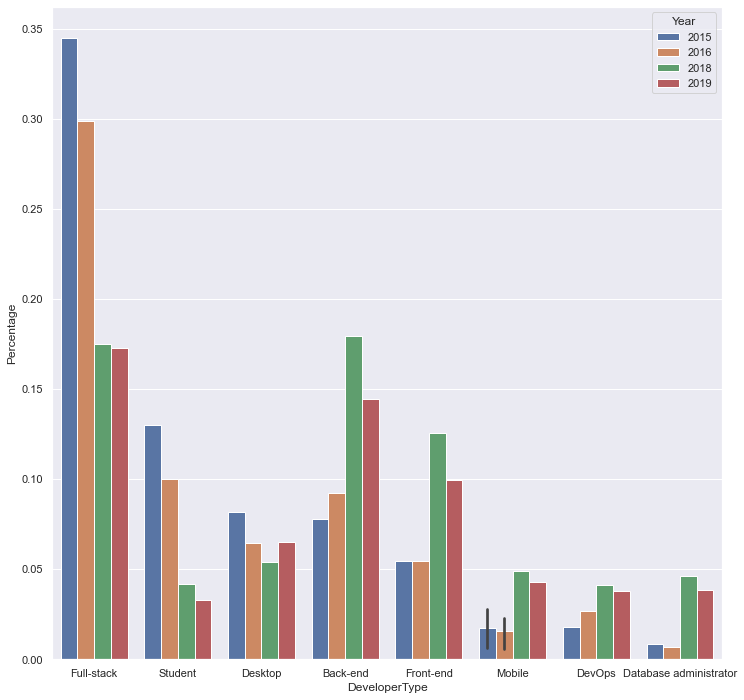

In [156]:
graph = sns.barplot(x="DeveloperType", y="Percentage", hue="Year", data=graph_data)

In [157]:
graph.figure.savefig("occupations.png")

<h3> Exploring 2019 data </h3>

In [158]:
# Now we are going to review 2019 data. Let's review the data first
united_states[2019].shape[0], united_states[2019].shape[1]

(20949, 85)

In [159]:
# There are 20,000 rows and 85 columns in 2019. Let's see what columns have missing data

<h3> Data Understanding </h3>

In [160]:
test_data = united_states[2019]
missing_cols = set(test_data.columns[test_data.isna().mean()>.2])

In [161]:
missing_cols

{'BlockchainIs',
 'BlockchainOrg',
 'CodeRevHrs',
 'CompFreq',
 'CompTotal',
 'ConvertedComp',
 'DatabaseDesireNextYear',
 'MgrIdiot',
 'MgrMoney',
 'MgrWant',
 'MiscTechDesireNextYear',
 'MiscTechWorkedWith',
 'PurchaseHow',
 'PurchaseWhat',
 'SOHowMuchTime',
 'SONewContent',
 'UnitTests',
 'WebFrameDesireNextYear',
 'WebFrameWorkedWith',
 'WorkWeekHrs'}

In [162]:
#10 features are missing more than 20 percent of the data. Let's review them

In [163]:
test_data["BlockchainOrg"]

3        Not at all
12       Not at all
21       Not at all
22              NaN
25       Not at all
            ...    
88818           NaN
88840           NaN
88844           NaN
88859           NaN
88877           NaN
Name: BlockchainOrg, Length: 20949, dtype: object

In [164]:
#Let's checkout BlockchainIs next

In [165]:
test_data["BlockchainIs"]

3        Useful for decentralized currency (i.e., Bitcoin)
12       Useful for decentralized currency (i.e., Bitcoin)
21                                                     NaN
22       Useful for immutable record keeping outside of...
25                                           A passing fad
                               ...                        
88818    Useful for immutable record keeping outside of...
88840                                                  NaN
88844                                                  NaN
88859    Useful for immutable record keeping outside of...
88877                    An irresponsible use of resources
Name: BlockchainIs, Length: 20949, dtype: object

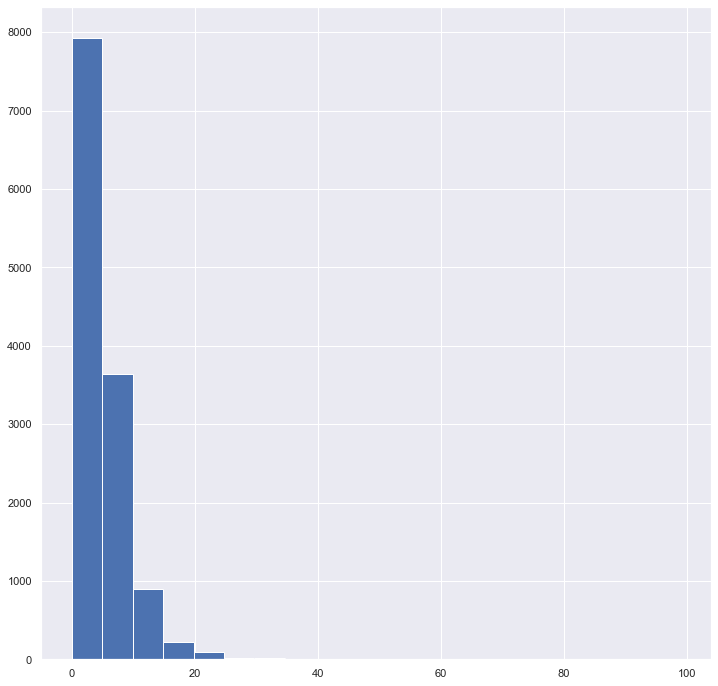

In [166]:
test_data["CodeRevHrs"].hist(bins=20)

In [167]:
test_data['DatabaseDesireNextYear']

3                                            MySQL;SQLite
12                                   Firebase;MySQL;Redis
21                       Elasticsearch;MySQL;Oracle;Redis
22       Couchbase;DynamoDB;Elasticsearch;Firebase;Oracle
25                Microsoft SQL Server;MySQL;Redis;SQLite
                               ...                       
88818                                              SQLite
88840                                                 NaN
88844                                                 NaN
88859                                                 NaN
88877                                                 NaN
Name: DatabaseDesireNextYear, Length: 20949, dtype: object

In [168]:
test_data["MiscTechDesireNextYear"]

3                           .NET
12            Node.js;TensorFlow
21                       Node.js
22       React Native;TensorFlow
25        .NET;.NET Core;Node.js
                  ...           
88818                        NaN
88840                        NaN
88844         Chef;Torch/PyTorch
88859                        NaN
88877                    Ansible
Name: MiscTechDesireNextYear, Length: 20949, dtype: object

In [169]:
test_data['MiscTechWorkedWith']

3                                  .NET
12                      Node.js;Xamarin
21                              Node.js
22                                  NaN
25       .NET;.NET Core;Node.js;Xamarin
                      ...              
88818                              Chef
88840                               NaN
88844                               NaN
88859                               NaN
88877                           Node.js
Name: MiscTechWorkedWith, Length: 20949, dtype: object

In [170]:
test_data["SOHowMuchTime"]

3        31-60 minutes
12       11-30 minutes
21        0-10 minutes
22                 NaN
25       11-30 minutes
             ...      
88818    11-30 minutes
88840      60+ minutes
88844              NaN
88859      60+ minutes
88877              NaN
Name: SOHowMuchTime, Length: 20949, dtype: object

In [171]:
test_data["SONewContent"].value_counts()

Tech articles written by other developers;Industry news about technologies you're interested in;Tech meetups or events in your area;Courses on technologies you're interested in    3113
Tech articles written by other developers                                                                                                                                           1404
Tech meetups or events in your area                                                                                                                                                 1199
Courses on technologies you're interested in                                                                                                                                        1185
Tech articles written by other developers;Courses on technologies you're interested in                                                                                              1147
Tech meetups or events in your area;Courses on technologies you're interest

In [172]:
test_data["WebFrameDesireNextYear"]

3                                          NaN
12                              Express;Vue.js
21            Angular/Angular.js;Ruby on Rails
22       Express;React.js;Ruby on Rails;Vue.js
25                  Angular/Angular.js;ASP.NET
                         ...                  
88818                                      NaN
88840                                      NaN
88844      Django;Drupal;Flask;jQuery;React.js
88859                                      NaN
88877                                   Vue.js
Name: WebFrameDesireNextYear, Length: 20949, dtype: object

In [173]:
test_data["WebFrameWorkedWith"]

3                                                      NaN
12        Angular/Angular.js;ASP.NET;Express;jQuery;Vue.js
21                        Angular/Angular.js;Ruby on Rails
22                                  React.js;Ruby on Rails
25       Angular/Angular.js;ASP.NET;Drupal;Express;jQue...
                               ...                        
88818                                                  NaN
88840                                                  NaN
88844                                                Flask
88859                                                  NaN
88877                                             React.js
Name: WebFrameWorkedWith, Length: 20949, dtype: object

In [174]:
# It looks like we have quite a few semicolon separated lists. Let's look for semicolons in every column

In [175]:
def get_all_semicolon_columns(df):
    col_lst = []
    for col in df.select_dtypes(include="object").columns:
        if sum(test_data[col].str.contains(";", na=False)) > 0:
            col_lst.append(col)
    return col_lst

In [176]:
semicolon_columns = get_all_semicolon_columns(test_data)

In [177]:
semicolon_columns

['EduOther',
 'DevType',
 'LastInt',
 'JobFactors',
 'WorkPlan',
 'WorkChallenge',
 'LanguageWorkedWith',
 'LanguageDesireNextYear',
 'DatabaseWorkedWith',
 'DatabaseDesireNextYear',
 'PlatformWorkedWith',
 'PlatformDesireNextYear',
 'WebFrameWorkedWith',
 'WebFrameDesireNextYear',
 'MiscTechWorkedWith',
 'MiscTechDesireNextYear',
 'DevEnviron',
 'Containers',
 'SOVisitTo',
 'SONewContent',
 'Gender',
 'Sexuality',
 'Ethnicity']

In [178]:
# We can create a lot of interesting charts if we clean these semicolon columns

<h3> Preparing Data </h3>
    
We can convert all semi-colon columns to dummy variables and sum the results of the dummy columns to find the most common responses
 

In [179]:
def clean_semi_colon(df, column_name):
    '''
    INPUT:
    df - Your dataframe. This function will create dummy variables for semicolons  
    column_name - The column you would like to split into dummy variables 
    
    OUTPUT:
    new_df - A new dataframe with all dummy variables and salary
    '''
    new_df = df[column_name].str.get_dummies(sep=";").add_prefix(column_name+ "_")
    new_df = new_df.join(df["CompTotal"])
    return new_df

In [180]:
# A function for renaming columns by splitting on '_' and retaining information after
split = lambda x:pd.Series(str(x).split("_"))

In [181]:
def barplot_by_column(df, column, min_salary=0):
    '''
    INPUT:
    df - Your dataframe. This function will create dummy variables for semicolons  
    column - The column you would like to analyze
    min_salary - You can slice the data above a certain salary
    
    OUTPUT:
    A bar graph of the 10 highest choices
    '''
    skills_df = clean_semi_colon(df, column)
    skills_df = skills_df[skills_df["CompTotal"] > min_salary]
    skills_df = pd.DataFrame(skills_df.sum()/skills_df.shape[0]).reset_index()
    skills_df.columns = ["Skill", "Percentage"]
    skills_df[["Junk", "Skill"]] = skills_df["Skill"].apply(split)
    skills_df = skills_df.sort_values(by="Percentage", ascending=False)
    ax = sns.barplot(x="Percentage", y="Skill", data=skills_df[0:10])
    #ax = ax.set_xlabel('Percentage')
    return ax

<h3> Question 3: What Skills do people want to learn next year? (From 2019) </h3>

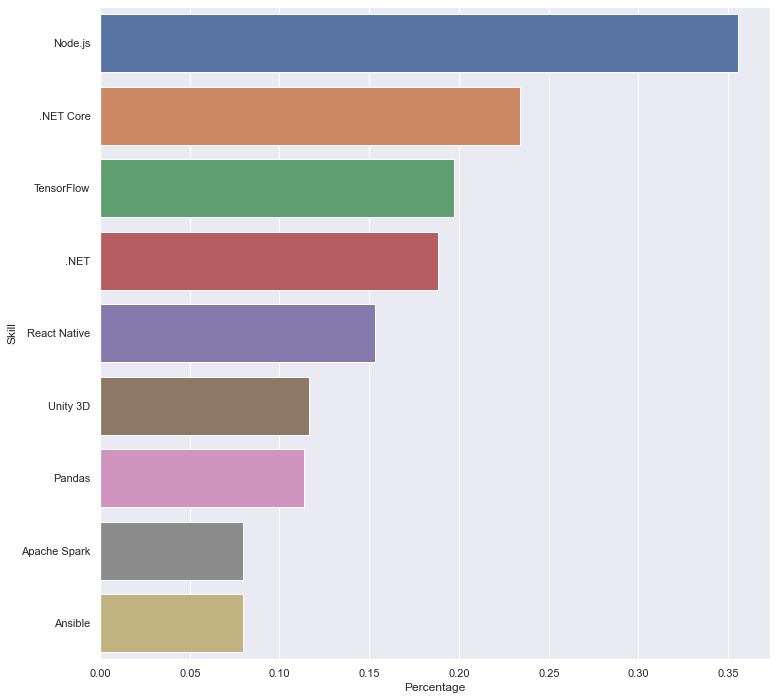

In [182]:
next_tech = barplot_by_column(test_data, "MiscTechDesireNextYear", 0)
next_tech.figure.savefig("next_tech.png")

<h3> Question 4: What languages do people work with now? </h3>

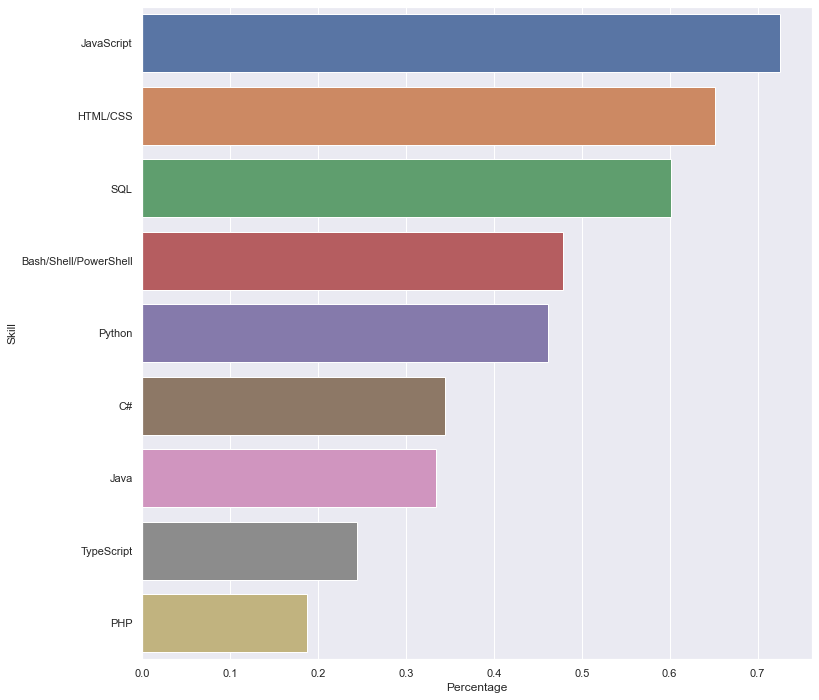

In [190]:
languages = barplot_by_column(test_data, "LanguageWorkedWith", 0)
languages.figure.savefig("languages.png", bbox_inches='tight')

<h3> Question 5: What web frameworks do they use most often? </h3>

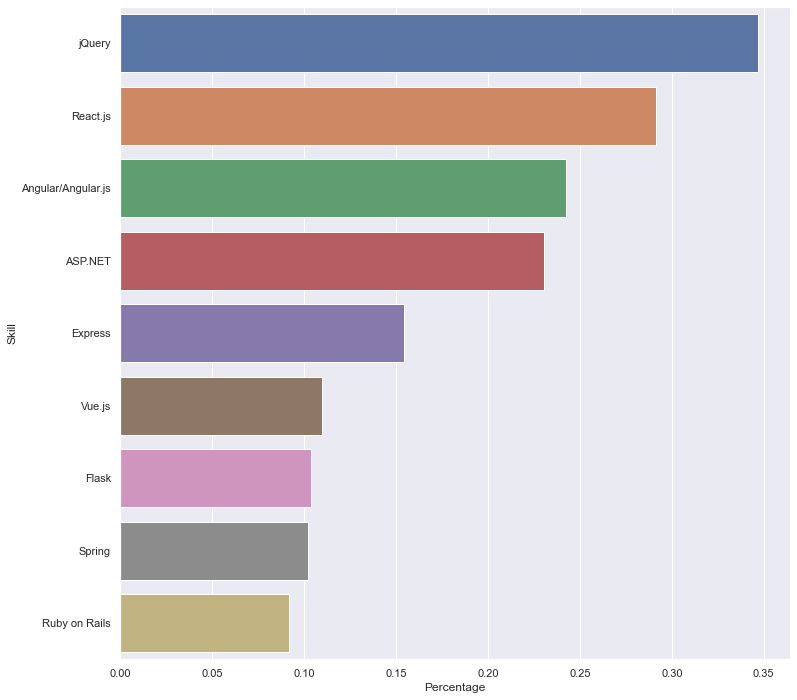

In [184]:
framework = barplot_by_column(test_data, "WebFrameWorkedWith", 0)
framework.figure.savefig("framework.png")

<h3> Question 6: What databases do they use most often? </h3>

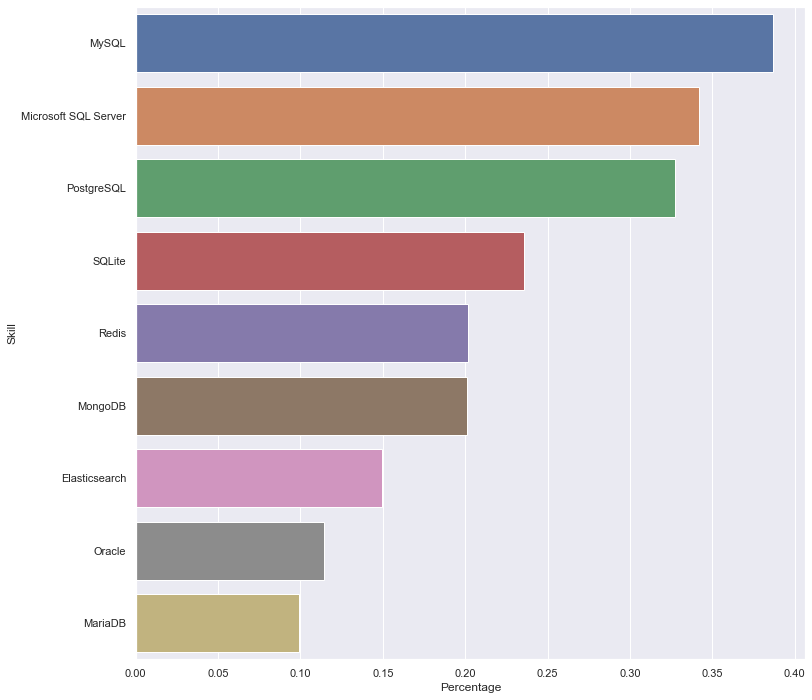

In [185]:
barplot_by_column(test_data, "DatabaseWorkedWith", 0)

<h3> Question 7: What is the biggest work challenge for developers? </h3>

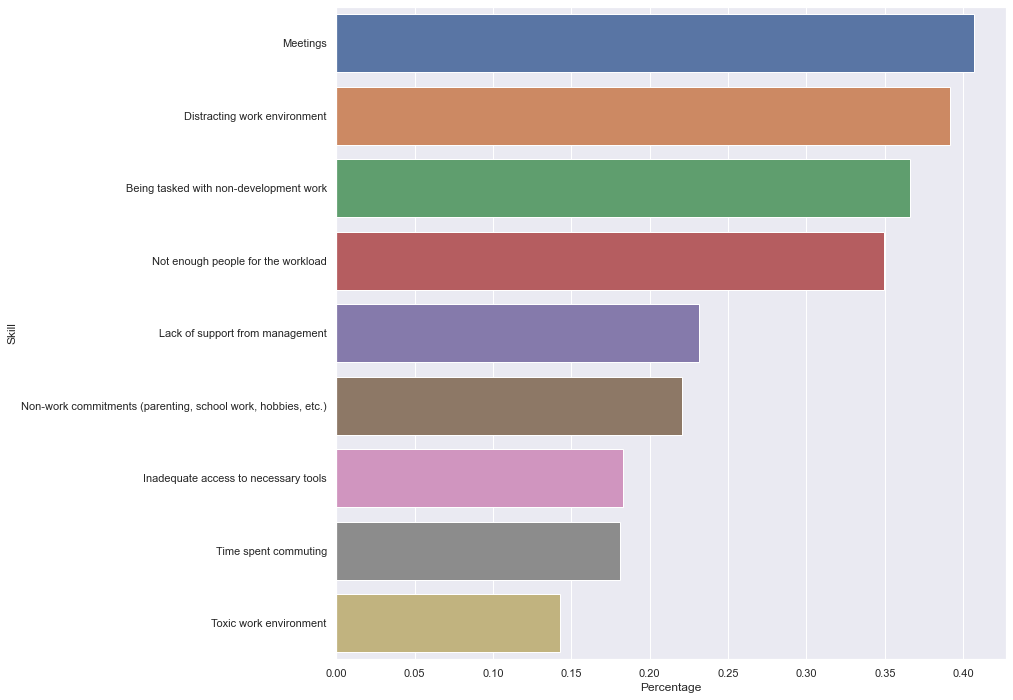

In [189]:
challenge = barplot_by_column(test_data, 'WorkChallenge', 0)
challenge.figure.savefig("challenge.png", bbox_inches='tight')

<h3> Question 8: What IDEs to people use? </h3>

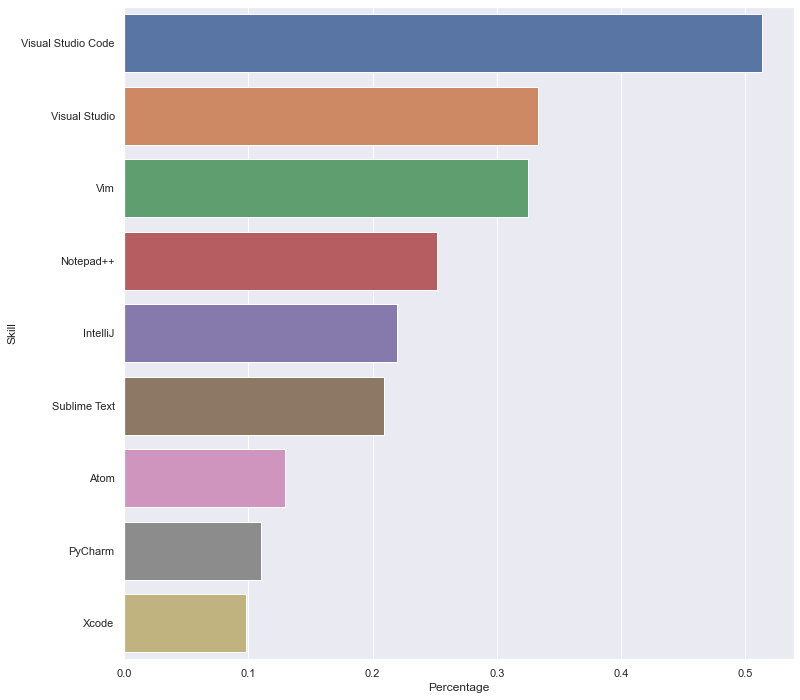

In [187]:
barplot_by_column(test_data, 'DevEnviron', 0)